In [1]:
from __future__ import print_function
from keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.models import Model
import numpy as np
import random
import sys
import io
import tensorflow as tf
import re
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt

#remove word Chapter
fin = open("/Users/neilwatt/Documents/BIs/PrWeb/2018Posts/August/TextGeneration/PrideAndPrejudice/Original.txt", encoding='utf-8')
fout = open("Clean.txt", "w+", encoding='utf-8')
delete_list = ['Chapter']
for line in fin:
    for word in delete_list:
        line = line.replace(word, "")
    fout.write(line)
fin.close()
fout.close()



Using TensorFlow backend.
/Users/neilwatt/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
#reading in copy of text with "Chapter" removed
Clean = '/Users/neilwatt/Documents/BIs/PrWeb/2018Posts/August/TextGeneration/PrideAndPrejudice/Clean.txt' # first command line arg
with io.open(Clean, encoding='utf-8') as f:
     Corpus = f.read().lower().replace('\n', ' \n ')

#remove numbers from text
text=re.sub(r"\b\d+\b", "", Corpus)

#review first 100 characters
text[:100]

' \n  \n  \n   \n  \n  \n it is a truth universally acknowledged, that a single man in possession \n of a go'

In [3]:


# runing this on a GPU as very computationally expensive
config = tf.ConfigProto()
#only allocate as much GPU memory based on runtime allocations, initially little but allows memory to be extended
config.gpu_options.allow_growth = True


chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters for calibrating model against
#here max length (maxlen) is pretty arbitrary, in future posts going to play around with this
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1



total chars: 52
nb sequences: 243191
Vectorization...


In [4]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
#the input shape is the max len of characters (set above)
#lens(chars) is simply the number of characters, in theory should consider controlling this

#the keras team use 128 units for a similar problem but this sis something we can optimise later
#note I added "return_sequences=True" to the first LSTM layer in the case where I added a second layer
model.add(LSTM(128,input_shape=(maxlen, len(chars))))
model.add(Dropout(0.2))
#the dense layer uses the number of characters as units
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

#lr=learning rate, i definately want to come back and optimise this later
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


Build model...


In [5]:
#temperature is a hyperparameter to control randomess of predictions by scaling logts before softmax
#temperature scales the logits before applying softmax

def sample(preds, temperature=0.5):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)




In [6]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [7]:
            
# define the checkpoint so I can load model in future
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                 
                             mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=2,
                              verbose=2)

#

# fit model using the gpu
#batch size is a particularly important hyperparamter which I intend to play around within future posts
with tf.device('/gpu:0'):

    history=model.fit(x, y,validation_split=0.1,batch_size=200,epochs=60,verbose=2,callbacks=[print_callback, checkpoint,earlystop])


Train on 218871 samples, validate on 24320 samples
Epoch 1/60
 - 201s - loss: 1.9718 - val_loss: 1.8161

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ir uncle is an attorney in 
 meryton.” 
"
ir uncle is an attorney in 
 meryton.” 
  
 “i dare any with the 
 sister to the 
 sister the 
 such a the sister with the reasing the sister of the couster the serised the say as the 
 mane the read to her sister, and the 
 mather the would not the 
 sister, whote with the consister, and she serserted that the 
 sister the would not the reasing to the 
 seried the say 
 coust the 
 sister to the reation that i should not the 
 sister t
----- diversity: 0.5
----- Generating with seed: "ir uncle is an attorney in 
 meryton.” 
"
ir uncle is an attorney in 
 meryton.” 
  
 “i do rist that her all the alled a like that sister of michtent with ving that 
 the 
 such of the loughtion to the out, and the compliestony that whom his for 
 sister 
 thought of the re

/Users/neilwatt/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


er wimer us the the word; sures from her knowing acauting had proacking to je returner, trate, in a be to selte me as enough an rome is he gaining that for theacted 
 them a 
 taw menthion, i fall elizabeth, partly, been setaled her comperrely on lyroned that my longalur him. lo

Epoch 00005: loss improved from 1.42723 to 1.39615, saving model to weights.hdf5
Epoch 6/60
 - 189s - loss: 1.3776 - val_loss: 1.6117

----- Generating text after Epoch: 5
----- diversity: 0.2
----- Generating with seed: "it, the application 
 was a something to"
it, the application 
 was a something to her and the subject; and i have been the 
 words the subject; and i have been 
 the reason the 
 subject, and the subject, and which and the last to the subject of the 
 sollous of the 
 convinced the 
 most convinced to be in the 
 seemed and her father of his proper the soon with the reason as the 
 before they were of the most side to his attentions of the subject of the 
 second the 
 the wor
----- diversit

In [41]:

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 40, 128)           92672     
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                35800     
_________________________________________________________________
dense_8 (Dense)              (None, 52)                2652      
_________________________________________________________________
activation_8 (Activation)    (None, 52)                0         
Total params: 131,124
Trainable params: 131,124
Non-trainable params: 0
_________________________________________________________________


In [23]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [13]:
history.history['val_loss']

[1.8160580198623633,
 1.6854135823485099,
 1.6601390634712421,
 1.644101312874179,
 1.6363008394837379,
 1.6117457929802568,
 1.6042297762867652,
 1.6183129772543907,
 1.6188319050952007]

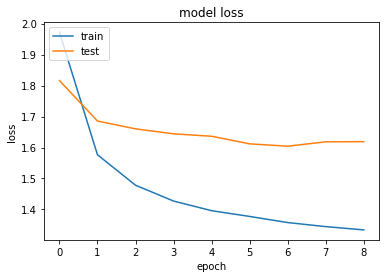

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
#let's now generate some text using the model
def generate_output():
    generated = ''
    usr_input = input("Input some sample text and the model will attempt to complete it in Jane Austen style. Your input is: ")
    sentence = ('{0:0>' + str(maxlen) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is the end of your story: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        
        x = np.zeros((1, maxlen, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x[0, t, char_indices[char]] = 1.

        
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, temperature = 1.0)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [16]:


generate_output()

Input some sample text and the model will attempt to complete it in Jane Austen style. Your input is: Away with you Darcy.


Here is the end of your story: 

Away with you Darcy. bingley's word. then from it. 
  
  
   
  
  
 elizabeth was beause of him so, o

/Users/neilwatt/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


f oeling night be he of my moneyer she would distince every ulless. some man friend concern my orgaice to upe were receive father had even as misdre, though this all not the nestered, on very interest the oouve been mean benice 
 trati all mes. benness with 
 to ocyer had his into wrote though of 
 contrained with fr